In [1]:
import os
import pandas as pd
import numpy as np
from scipy.io import wavfile as wav
from scipy.fft import fft
import matplotlib.pyplot as plt

from scipy.signal import spectrogram
from tqdm import tqdm
import itertools as it
from sklearn.model_selection import train_test_split
from sklearn import tree
import sklearn.metrics as metrics
import random

#accessing the folder in which files are stored
jup_PATH = os.getcwd()

os.chdir(jup_PATH+"/free-spoken-digit")
data_PATH = os.path.basename(os.getcwd())

os.chdir("dev")
dev_PATH = os.path.basename(os.getcwd())

audios = os.listdir()

TO_AUDIOS = jup_PATH + "/" + data_PATH + "/" + dev_PATH + "/"

In [2]:
signals = pd.DataFrame()

signals["FILE"] = os.listdir(TO_AUDIOS)

readings = []
for f in signals["FILE"]: 
    
    r = f.split(sep = ".")[0]
    r = r.split(sep = "_")[1]
    
    readings.append(r)

signals["NUMBERS"] = readings
signals.set_index("NUMBERS", inplace = True)

In [3]:
sig_sample = pd.DataFrame(columns = ["FILE"])
"""
sig_sample: the dataframe containing a small percentage of the data in which the index is the number being read 
            and in the "FILES" columns there is the name of the recording related to the given number
"""

#sample fraction overall
FRACTION = 1

for label in range(0,10): 
    label = str(label)
    
    usable = (signals.groupby(level = 0).get_group(name = label))
    sig_sample = sig_sample.append(usable.sample(frac = FRACTION, random_state = 1))

sig_sample = sig_sample.reset_index().rename(columns = {"index":"label"})

Now I have a freshly usable dataframe, *sig_sample*, which collect the 20% only of the recordings of a single number.

## Accessing the waveforms

In [4]:
def normalize(array, criteria = "min,max"): 
    """
    Normalizes a given array according to a specific array. 
    -------
    Paramethers: 
    array: array to be normalized
    
    criteria: 
            min,max: normalizes the array with respect to minimal and maximal value
            z: normalizes the array using z-normalization
            norm_2: transform the prompted array in an unitary array
    ---------
    Returns: 
    multiple returns, basically an array.
    
    """
    
    if criteria == "min,max": 
        return (array - np.min(array))/(np.max(array) - np.min(array))
    
    if criteria == "z": 
        return (array - np.mean(array))/np.std(array)
    
    if criteria == "norm_2": 
        return array/np.linalg.norm(array)

### Accessing the data
This section of code is mainly devoted to append to the *sig_sample* DataFrame a column in which the signal is presented as an array in the different domains.

In [5]:
AUDIO = []
F_AUDIO = []
EN_AUDIO = []
SPEC = []
TIME = []

for number in range(0,10): #transform in iterating over strings
    number = str(number)
    
    ser = sig_sample[sig_sample["label"] == number]
    
    for f in tqdm(ser.values[:,1]): 

        input_data = wav.read(f)
        s_rate = input_data[0]
        
        audio = normalize(input_data[1], criteria = "z")
        AUDIO.append(audio)
        TIME.append(len(audio)/s_rate)

        """
        DEV_ONLY: Reducing sample numerosity.
        """
        try: 
            audio = audio[0:VISUAL_BOUND]
        except: 
            audio = audio

        f_audio = normalize(fft(audio), criteria = "z")
        F_AUDIO.append(f_audio)
        
        en_audio = normalize(np.abs((f_audio)**2), criteria="z")
        EN_AUDIO.append(en_audio)
        
        SPEC.append(spectrogram(audio)[2])

sig_sample["Time Domain"] = AUDIO
sig_sample["Frequency Domain - amplitude"] = F_AUDIO
sig_sample["Frequency Domain - energy"] = EN_AUDIO
sig_sample["Spectrogram"] = SPEC
sig_sample["Time"] = TIME

#reshaping with respect to the index
sig_sample.set_index("FILE", inplace = True)

100%|██████████| 150/150 [00:00<00:00, 466.29it/s]


## Data cleaning
In this section the signals with a non statistical lasting are discarded in the sake of outliers detection. 

In [6]:
mul = 3

t_mean = np.mean(sig_sample["Time"])
t_std = np.std(sig_sample["Time"])

sig_sample = sig_sample.loc[
    (sig_sample["Time"] <= t_mean + mul * t_std) & sig_sample["Time"] >= t_mean - mul * t_std  
]

#display(sig_sample);

,label,Time Domain,Frequency Domain - amplitude,Frequency Domain - energy,Spectrogram,Time
FILE,,,,,,
496_0.wav,0,"[0.07519421437034045, 0.07519421437034045, 0.0...",[(-0.0012300512475623578+9.95304262271372e-19j...,"[-0.1721055058292778, -0.17032175703613694, -0...","[[0.14539537966988172, 1.2447603722656206, 0.2...",0.467125
1334_0.wav,0,"[0.11965775366258644, 0.1438212424448479, 0.16...",[(-0.0016739057605212905-6.224571219338309e-19...,"[-0.13459294293366567, -0.13456088199782945, -...","[[0.001000847262272821, 0.018548544944232064, ...",0.638750
112_0.wav,0,"[0.16401507418685426, 0.3304561505275553, 0.33...",[(-0.002646102145333039-9.547851633022525e-19j...,"[-0.13463581391952706, -0.13291029492092868, -...","[[0.9377648018057558, 0.0882783334119068, 3.72...",0.480250
865_0.wav,0,"[-0.09231652236752204, -0.15120712692754476, -...","[(0.001562893847780635+8.27466693126032e-19j),...","[-0.17430055843353198, -0.17217891793863627, -...","[[0.2529110456379444, 1.6557948082848437, 0.84...",0.436125
815_0.wav,0,"[-0.022674149876048662, -0.0271840338317484, -...",[(0.00045069732924465905+1.3392549858907186e-1...,"[-0.2327405029322003, -0.231477089171949, -0.2...","[[0.09182765453897831, 0.6743800975898644, 0.0...",0.316375
...,...,...,...,...,...,...
203_9.wav,9,"[-0.0845024508376222, -0.09578999823845184, -0...",[(0.001472116112591758-1.2021468542077859e-18j...,"[-0.20333131688572775, -0.20327837777597835, -...","[[2.413887861594421e-05, 0.20967743879960293, ...",0.411875
1082_9.wav,9,"[-0.07645212586928367, -0.09164287421671369, -...",[(0.001813111037281086+1.1372986633633389e-18j...,"[-0.3358110726390557, -0.33567191863135143, -0...","[[0.056220416646270935, 0.5809334273848286, 0....",0.222250
1054_9.wav,9,"[0.059224074442093266, 0.06879456769273727, 0....",[(-0.0008212114609472412-2.2732192005535446e-1...,"[-0.11628224075638754, -0.11627225066878359, -...","[[0.4485842781407678, 0.024208418970985756, 0....",0.650125


### Plotting

This section of the code basically serves as a section in which perform some exploratory tecnique to get to better know the data.
This is the reason why the already sampled subset of all the audios are being re-sampled in order to obtain some quick idea on how to treat this particular type of data.

100%|██████████| 1484/1484 [00:00<00:00, 4293.24it/s]


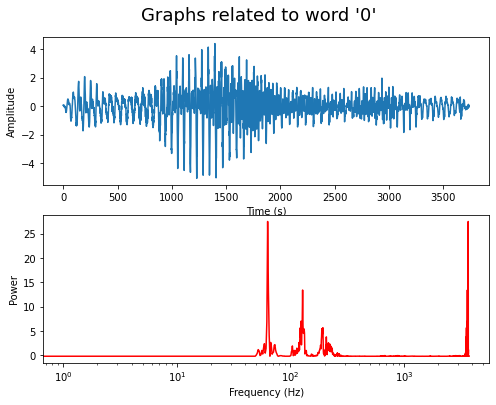

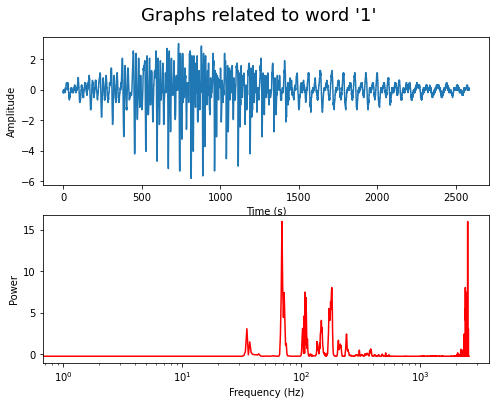

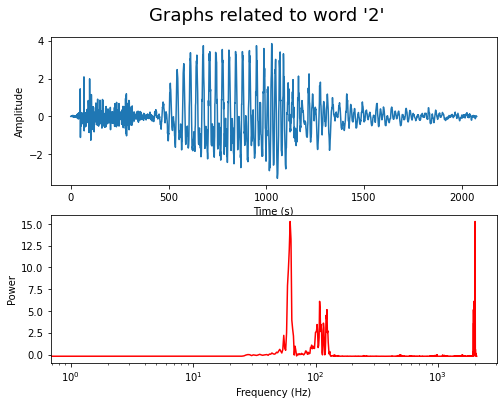

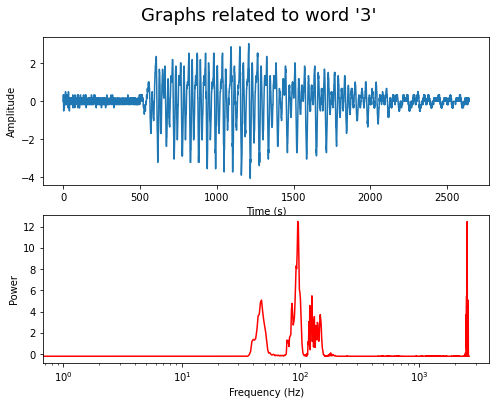

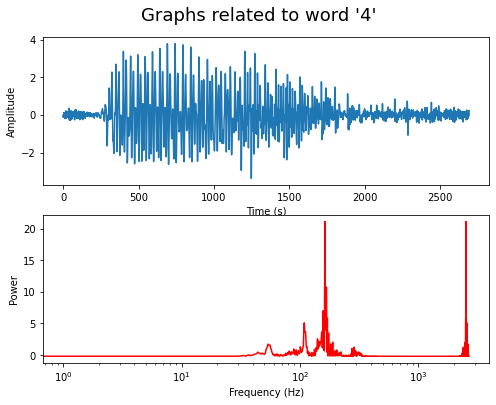

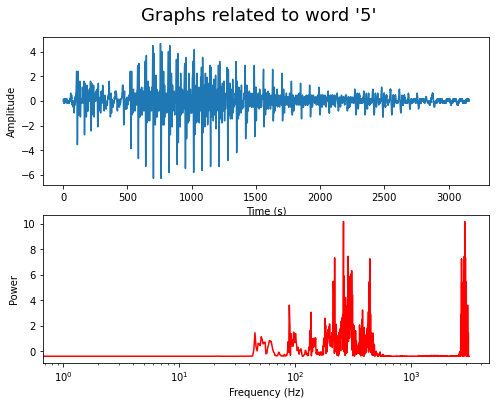

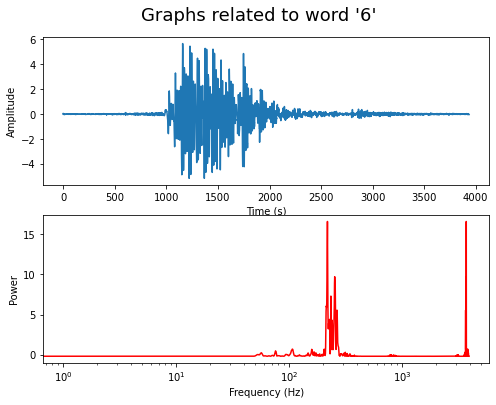

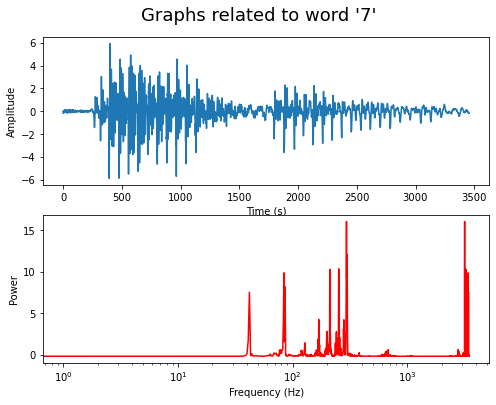

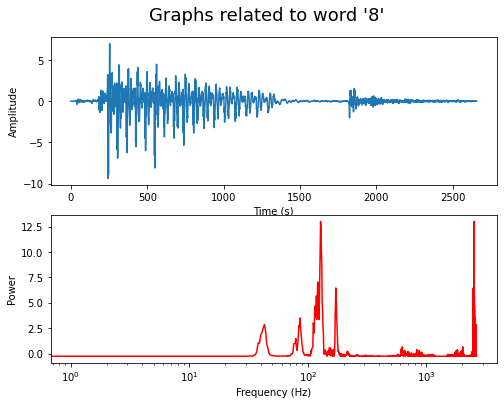

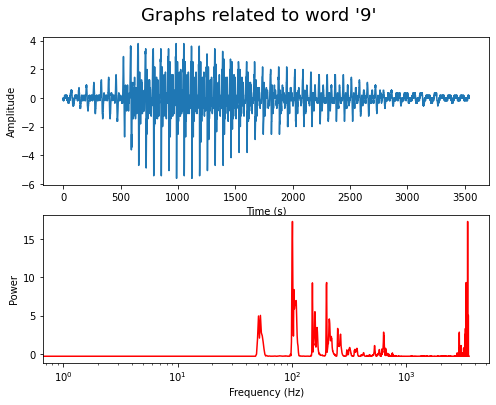

In [7]:
# VISUAL_BOUND = 10

seen = []
for file in tqdm(sig_sample.index):
    number = sig_sample.loc[file, "label"]
    
    if number not in seen: 
        seen.append(number)
        input_data = wav.read(file)
        audio = normalize(input_data[1], criteria = "z")

        """
        DEV_ONLY: Reducing sample numerosity.
        """
        try: 
            audio = audio[0:VISUAL_BOUND]
        except: 
            audio = audio

        f_audio = normalize(fft(audio), criteria = "z")

        en_audio = normalize(np.abs((f_audio)**2), criteria="z")

        fig, axs = plt.subplots(nrows = 2, figsize = (8,6))

        fig.suptitle(f"Graphs related to word '{number}'", y = 0.95, size = 18)

        #time domain representation
        axs[0].plot(audio)
        axs[0].set_ylabel("Amplitude")
        axs[0].set_xlabel("Time (s)")

        #frequency domain representation
        #axs[1].plot(f_audio, color = "r")
        #axs[1].set_xlabel("Frequency (Hz)")
        #axs[1].set_xscale("log")
        #axs[1].grid(which="both")

        #frequency domain representation of square modules
        axs[1].plot(en_audio, color = "r")
        axs[1].set_xlabel("Frequency (Hz)")
        axs[1].set_ylabel("Power")
        axs[1].set_xscale("log")
        
    else: 
        continue

## The spectrogram

Since a spectrogram is defined as a $n \times m$ matrix defying a signal in the way it behaves both in the time and in the frequency domain, to use it a tool for signal classification seems almost immediate.
The problem is that for the spectrogram usually $n$ and $m$ are quite big, hence it is not possible to process them with the usual tecnique in a suitable amount of time and one should always go to *dimension reduction* to solve this issue. 

The reduction of the dimension of the spectogram tipically consists in a process with which the size gets reshaped using *chunks* described by statistical value rather than the whole grid.

In [8]:
sig_sample;

In [9]:
def syntetize_spectr(spectr, N, M): 
    """
    This function is used to syntetize a given matrix "spectr" of shape spectr.shape[0]xspectr.shape[1] into an intermediate matrix
    of dimension NxM to then finally flatten this intermediate matrix into an array of lenght NxM.
    This particular function has been defined in the context of spectrum analysis, hence the intermediate matrix is not just one, but two, and
    the final array contains 2*NxM elements. 

    ---------
    Paramethers:
    spectr: the given matrix to syntetize in the output array.
    N: scalar. Number of rows in the intermediate matrix.
    M: scalar. Number of columns in the intermediate matrix. 

    Returns: 
    An (NxM*2,) array that serves as a syntesis of the given spectrum.
    """

    
    synt = np.zeros(shape = (N,M))
    N_in, M_in = spectr.shape
    
    n_positions = [n*N_in//N for n in range(N+1)]
    m_positions = [m*M_in//M for m in range(M+1)]
    
    combinations = set()
    for n_pos in n_positions: 
        for m_pos in m_positions:
            combinations.add((n_pos, m_pos))
            
    output_mean = np.ones(shape = (N,M))
    output_std = np.ones(shape = (N,M))
    
    """
    populating the output dataset with the summaryzed data
    """
    for r_idx in range(len(n_positions)-1): 
        r_in_pos = n_positions[r_idx]
        r_end_pos = n_positions[r_idx + 1]

        for c_idx in range(len(m_positions)-1):

                c_in_pos = m_positions[c_idx]
                c_end_pos = m_positions[c_idx + 1]

                output_mean[r_idx, c_idx] = np.mean(spectr[r_in_pos:r_end_pos, c_in_pos:c_end_pos])
                output_std[r_idx, c_idx] = np.std(spectr[r_in_pos:r_end_pos, c_in_pos:c_end_pos])
                
    mean_row = output_mean.flatten()
    std_row = output_std.flatten()

    return np.hstack((mean_row, std_row))

In [10]:
N = 8
M = 4

files = sig_sample.index
out = pd.DataFrame(index = files, columns = [f"feature_{i+1}" for i in range(N*M*2)])

for file in tqdm(files):
    
    spectrum = sig_sample.loc[file, "Spectrogram"]
    out.loc[file, :] = syntetize_spectr(spectrum, N = N, M = M)

out["LABEL"] = sig_sample["label"]

100%|██████████| 1484/1484 [00:02<00:00, 596.24it/s]


In [11]:
X = out.iloc[:, :-1]
y = out["LABEL"]

X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size = 0.20)

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators = 350,
                             max_features = 3*round(np.sqrt(len(X_train_valid.columns))),
                             criterion = "entropy")

clf.fit(X_train_valid, y_train_valid)

accuracy = metrics.accuracy_score(y_test, clf.predict(X_test))
f1 = metrics.f1_score(y_test, clf.predict(X_test), average = "macro")

print("Score is {:.2f} %".format(accuracy*100))
print("F1_Score is {:.2f} %".format(f1*100))

Score is 93.27 %
F1_Score is 92.97 %


## Performance on the eval folder
This section of the code applies the classifier *clf* defined in the previous cell to the data contained into the *eval* folder, i.e. unlabelled data.

In [13]:
os.chdir(jup_PATH+"/"+data_PATH+"/"+"eval")
TEST_AUDIO = os.listdir()

In [14]:
SPEC = []
eval_df = pd.DataFrame(index = TEST_AUDIO)

for t_file in TEST_AUDIO: 
    
    input_data = wav.read(t_file)
    audio = normalize(input_data[1], "z")
    
    SPEC.append(spectrogram(audio)[2])

eval_df["Spectrogram"] = SPEC

N = 8
M = 4

X = pd.DataFrame(index = eval_df.index, 
                 columns = [f"Feature_{i+1}" for i in range(2*N*M)])

for f in eval_df.index: 
    spectrum = eval_df.loc[f, "Spectrogram"]
    X.loc[f, :] = syntetize_spectr(spectrum, N = N, M = M)

In [15]:
"""
Using the afore defined model to predict on the data contained in the "eval" folder
"""
eval_pred = clf.predict(X)

In [16]:
to_commit = pd.DataFrame()
to_commit["Predicted"] = eval_pred
to_commit["Id"] = [id_.split(".")[0] for id_ in eval_df.index]
to_commit.set_index("Id", inplace = True)
to_commit.astype(int)

os.chdir(jup_PATH) 
to_commit.to_csv("predictions.csv")